#### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import scanpy as sc
import anndata as ad
import squidpy as sq
import matplotlib.pyplot as plt

#### Loading data

In [2]:
cell_assignments = pd.read_csv('cell_assignments_filtered.csv')
region_assignments = pd.read_csv('concordex_cerebellum_res_2024-06-10.csv')
cereb_coords = np.load('cerebellum_coords_mat.npy')
cereb_counts = np.load('cerebellum_counts_mat.npy')
gene_labels = np.load('cerebellum_gene_labels.npy', allow_pickle=True)

cell_assignments = cell_assignments['first_type']
region_assignments = region_assignments['concordex_pred']

#### Preprocessing

In [3]:
# Setting up AnnData object
cereb_adata = ad.AnnData(cereb_counts)
cereb_adata.obs_names = ['Bead_'+str(i) for i in range(cereb_adata.n_obs)]
cereb_adata.var_names = gene_labels
cereb_adata.obs['cell_type'] = pd.Categorical(cell_assignments)
cereb_adata.obs['region'] = pd.Categorical(region_assignments)

# inverting y_coordinates because spatial plotting libraries were plotting the cerebellum
# upside down from usual display
x = cereb_coords[:, 0]
y = cereb_coords[:, 1]
new_y = y.max() - y
new_cereb_coords = np.array(list(zip(x, new_y)))
cereb_adata.obsm['spatial'] = new_cereb_coords


# Calculating % MT counts
mt_gene_ids = [i for i in range(14089, 14160)] + [i for i in range(23068, 23092)] # figured out these are the correct indices
mt_pcts = []
counts_matrix = cereb_adata.X
for bead_num in range(cereb_adata.n_obs):
    mt_pcts.append(np.sum(counts_matrix[bead_num][mt_gene_ids])/np.sum(counts_matrix[bead_num]))

cereb_adata.obs['pct_counts_mt'] = mt_pcts


# Filtering
print('Initial cells:', cereb_adata.n_obs)
print('Initial genes:', cereb_adata.n_vars)
sc.pp.filter_genes(cereb_adata, min_counts=50)
sc.pp.filter_genes(cereb_adata, min_cells=25)
cereb_adata = cereb_adata[cereb_adata.obs["pct_counts_mt"] < 0.1].copy()
print('Final cells:', cereb_adata.n_obs)
print('Final genes:', cereb_adata.n_vars)


# Finding total_counts (per gene) and n_cells_by_counts
cereb_adata.var.rename(columns={'n_counts':'total_counts', 'n_cells':'n_cells_by_counts'}, inplace=True)
    # filtering process somehow creates columns but we need to rename and reevaluate post-filtering

# Finding total_counts (gene) and n_cells_by_counts
cells_expressing  = []
expressions = []
X = cereb_adata.X.T 
    # transposes rows and columns so that genes are now rows
for gene_num in range(cereb_adata.n_vars):
    expressions.append(np.sum(X[gene_num]))
    cells_expressing.append(np.count_nonzero(X[gene_num]))

cereb_adata.var['n_cells_by_counts'] = cells_expressing
cereb_adata.var['total_counts'] = expressions


# Finding total_counts (cell) and n_genes_by_counts
genes_expressed  = []
total_counts = []
X = cereb_adata.X
for bead_num in range(cereb_adata.n_obs):
    total_counts.append(np.sum(X[bead_num]))
    genes_expressed.append(np.count_nonzero(X[bead_num]))

cereb_adata.obs['n_genes_by_counts'] = genes_expressed
cereb_adata.obs['total_counts'] = total_counts


# Normalization + log1p
sc.pp.normalize_total(cereb_adata)
sc.pp.log1p(cereb_adata)


# Finding post-normalization log1p_total_counts (cell and gene)
    # cell
total_counts = []
X = cereb_adata.X
for bead_num in range(cereb_adata.n_obs):
    total_counts.append(np.sum(X[bead_num]))

cereb_adata.obs['log1p_total_counts'] = total_counts

    # gene
total_counts = []
X = cereb_adata.X.T
for gene_num in range(cereb_adata.n_vars):
    total_counts.append(np.sum(X[gene_num]))

cereb_adata.var['log1p_total_counts'] = total_counts

Initial cells: 9985
Initial genes: 23096
Final cells: 9051
Final genes: 10293


#### Work

In [4]:
#                blue/gran   green/PB  orange/oligo red/MLI     gray
master_palette = ['#1A476F', '#55752F', '#E69F00', '#C10534','#C1C1C1']

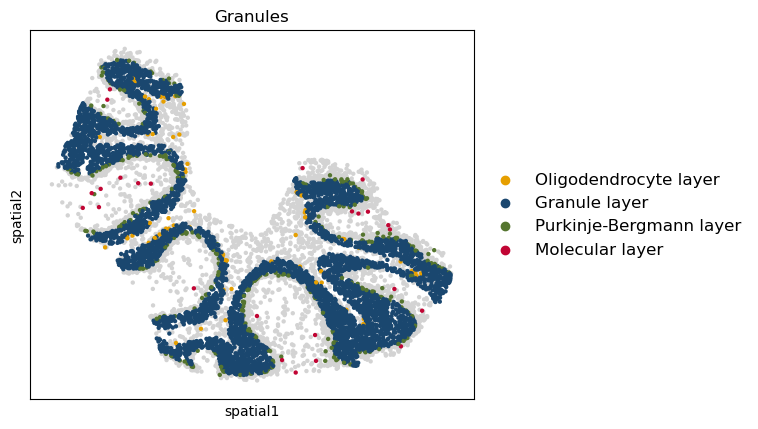

In [5]:
cell_type = 'Granule'

types = list(cereb_adata.obs['cell_type'])
regs = list(cereb_adata.obs['region'])

oli_data = []
common_region_names = ['Granule layer', 'Purkinje-Bergmann layer', 'Oligodendrocyte layer', 'Molecular layer']
for i, reg in enumerate(regs):
    if types[i] == cell_type:
        oli_data.append(common_region_names[reg])
    else:
        oli_data.append('other')

# for all cells
# oli_data = pd.Categorical([common_region_names[reg] for reg in regs], categories=['Oligodendrocyte layer', 'Granule layer', 'Purkinje-Bergmann layer', 'Molecular layer'], ordered=True)

# for a specific cell type
oli_data = pd.Categorical(oli_data, categories=['Oligodendrocyte layer', 'Granule layer', 'Purkinje-Bergmann layer', 'Molecular layer', 'other'], ordered=True)

color_dict = dict(zip(list(['Granule layer', 'Purkinje-Bergmann layer', 'Oligodendrocyte layer', 'Molecular layer', 'other']), master_palette))

cereb_adata.obs['oli_data'] = oli_data

fig, ax = plt.subplots()

sc.pl.spatial(
    cereb_adata,
    color='oli_data',
    groups=['Granule layer', 'Purkinje-Bergmann layer', 'Oligodendrocyte layer', 'Molecular layer'],
    spot_size=50,
    title=cell_type+'s',
    palette=color_dict,
    legend_fontsize='large',
    na_in_legend=False,
    show=False,
    ax=ax
)


plt.show()
# plt.savefig('./figures/grans.png', dpi=150, bbox_inches='tight')

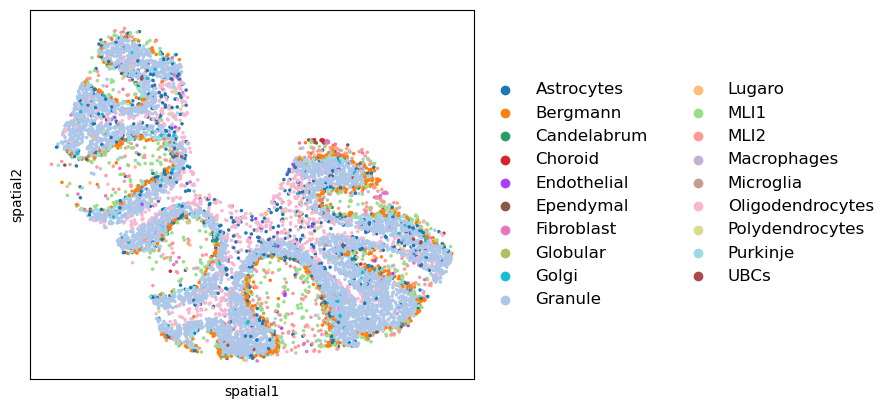

In [6]:
fig, ax = plt.subplots()

sc.pl.spatial(
    cereb_adata,
    color='cell_type',
    # groups=['Astrocytes', 'Bergmann', 'Granule', 'MLI1', 'MLI2', 'Oligodendrocytes', 'Purkinje'],
    spot_size=40,
    title='',
    legend_fontsize='large',
    na_in_legend=False,
    show=False,
    ax=ax
)

# plt.savefig('./all_cells.png', dpi=150, bbox_inches='tight')
plt.show()